In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

In [2]:
positions = ["PosX", "PosY", "PosZ"]
rotations = ["RotX", "RotY", "RotZ"]
tmp = positions + rotations


path = r'../from_study/CSV' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, delimiter=";")
    li.append(df)


def calc_euc(df):
    for pos in positions:
        df[pos + "_diff"] = df[pos] - df[pos].shift(1)
        df[pos + "_square"] = df[pos + "_diff"] * df[pos + "_diff"]

    df["euc"] = (df["PosX_square"] + df["PosY_square"] + df["PosZ_square"]).apply(lambda x: np.sqrt(x))
    return df["euc"].sum()

In [3]:
df_result = pd.DataFrame(columns=['PID','condition','movement'])
for j in range(len(li)):
    df = li[j]
    df = df[(df.isStudy == True)]
    # filter unusual data
    df = df[(df.PosX < 10) & (df.PosX > -10)]
    df = df[(df.PosY < 10) & (df.PosY > -10)]
    df = df[(df.PosZ < 10) & (df.PosZ > -10)]
    for i in range(1, 4):
        right = df[(df.Hand == "Right") & (df.Condition == i)]
        left = df[(df.Hand == "Left") & (df.Condition == i)]
        tmp = calc_euc(right) + calc_euc(left)
        pid = df.SubjectID.unique()[0]
        df_result = df_result.append({'PID': pid, 'condition': i, 'movement': tmp}, ignore_index=True)
        # print("PID", pid, "-", "condition", str(i), ":\t", tmp)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
df_result["PID"] = pd.to_numeric(df_result["PID"]).astype(int)
df_result["condition"] = pd.to_numeric(df_result["condition"]).astype(int)

In [5]:
df_result.groupby(["condition"]).movement.describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
1,12.0,71.271603,33.819030,13.868938,54.588462,65.702882,86.344528,140.308256
2,12.0,64.517381,34.622370,21.475518,43.877621,53.898466,81.488739,140.276817
3,12.0,67.556325,26.522171,27.787852,49.864273,63.915033,73.766878,120.113180


presence ist gleich wie bei condtions

eigene presence ist daher nicht beeinflusst

# plot results

In [6]:
df_result.head()

,PID,condition,movement
0,21,1,98.842364
1,21,2,65.589313
2,21,3,70.995867
3,52,1,55.447629
4,52,2,46.554299


In [7]:
df_result.to_csv("distance.csv")

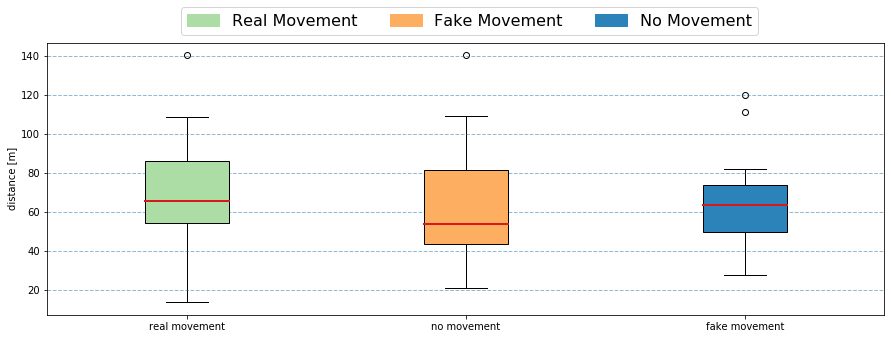

In [8]:
fig, ax = plt.subplots(1,figsize = (15,5))

plt.rcParams.update({'font.size': 16})


colors = ['#abdda4','#fdae61','#2b83ba','#d7191c']

data = []

for c in df_result.condition.unique():
    x = df_result[df_result.condition == c]["movement"].values
    data.append(x)
    
bp = ax.boxplot(data, positions = [1,2, 3], patch_artist=True)

i = 1
for box in bp['boxes']:
    if i % 3 == 1:
        # change fill color
        box.set( facecolor = colors[0] )
    elif i%3 == 2:
        box.set( facecolor = colors[1] )
    else:
        # change fill color
        box.set( facecolor = colors[2] )
    i += 1

for median in bp['medians']:
    median.set(color=colors[3], linewidth=2)
    
    
for i in range(1,8):
    ax.axhline(y=i * 20, xmin=0, xmax=140, linestyle = "--", alpha = 0.5,linewidth = 1)

    
question_labels = ['Real Movement', 'Fake Movement', 'No Movement']

patches = []
for i in range(len(question_labels)):
    patch = mpatches.Patch(color=colors[i], label=question_labels[i])
    patches.append(patch)

plt.legend(handles = patches,ncol = 3, bbox_to_anchor=(0.15, 1))
xtick_labels = ["real movement","no movement","fake movement"]
plt.xticks(np.arange(1, 4), xtick_labels)


ax.set_ylabel("distance [m]")
plt.savefig("euclideandistance.pdf", bbox_inches="tight")
plt.savefig("euclideandistance.svg", bbox_inches="tight")
plt.show()

# average times

In [9]:
df_result = pd.DataFrame(columns=['PID','condition','timestamp'])
times = [[] for i in range(3)]
for j in range(len(li)):
    df = li[j]
    df = df[(df.isStudy == True)]
    for cond in df.Condition.unique():
        df_tmp = df[(df.Condition == cond)]
        delta = df_tmp['timestamp'].iat[-1] - df_tmp['timestamp'].iat[0]
        times[cond - 1].append(delta)
time_cond = []
for cond in sorted(df.Condition.unique()):
    time_delta = sum(times[cond - 1]) / len(times[cond - 1])
    time_cond.append(time_delta)
    print(cond, (time_delta / 1000) / 60)
print("total", ((sum(time_cond) / len(time_cond)) / 1000) / 60)

1 7.212330555555555
2 6.556254166666666
3 6.354723611111112
total 6.707769444444446
